# Ortholog Finding
#### This module was originally created for cas9 but could extended to any protein.

## Step 1: Profile the Protein
    1. Mean, max, min length of already known orthologs
## Step 2: HMM Seach
    1. Align orthologs
    2. build hmm profile
    3. hmm search against a database
## Step 3: Profile Results
    1. Read hmm results
    2. cluster results by percent identity
    3. remove proteins without required domains


### Env

<p>
conda create --name casenv <br/>
conda install -n casenv libgcc hmmer mafft biopython <br/>
source activate casenv
</p>

In [1]:
%matplotlib inline
import re
from sys import path as spath
spath.append("scripts/")

from Bio.SeqIO import write, parse
from collections import Counter
from CRISPRtools import CasOperon
from easyFunctions import *
from HMMParser import *
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from os import chdir, listdir
from pandas import Series
from pickle import load #Dump has been wrapped aournd a function from easyFunctions

chdir("data")

### Gene Orthologs Fasta File

In [2]:
gene = "Cas9"
geneProfile = "proteins/DiverseCas9s.faa" #File containing the seed proteins for the hmmsearch
geneFile = "proteins/%s.faa" % gene
alnName  = "alignments/%s.aln" % gene
hmmName  = "hmm/%s.hmm" % gene
hmmResultsDir = "hmm/results"
baseDbsDir = "/mnt/research/germs/shane/databases/assemblies/"
refDatabases = ["NCBI/refseq/bacteria","NCBI/refseq/archaea","NCBI/genbank/bacteria","NCBI/genbank/archaea","PATRIC2/fastas"]

### Profile the gene

In [3]:
dists = []
for rec in parse(geneProfile,"fasta"):dists.append(len(rec.seq))
dists = Series(dists)
minSeqLen = int(dists.min() - (dists.mean() * .25))
maxSeqLen = int(dists.max() + (dists.mean() * .25))
print (dists.describe());
print ("Finding proteins that match the protein profile and are between %i and %i" % (minSeqLen, maxSeqLen))

count      84.000000
mean     1243.547619
std       160.535955
min       984.000000
25%      1099.750000
50%      1207.500000
75%      1376.500000
max      1688.000000
dtype: float64
Finding proteins that match the protein profile and are between 673 and 1998


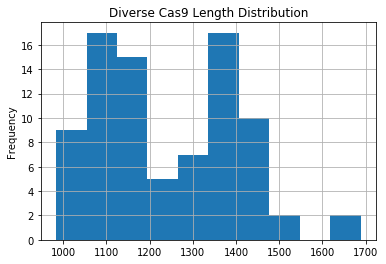

In [4]:
import matplotlib.pyplot as plt
dists.plot(kind='hist',grid=True,title="Diverse Cas9 Length Distribution",figsize=(6,4))
plt.savefig("images/DiverseCas9Lengths.png")
plt.show()

### Make HMM

In [ ]:
%%bash -s $geneProfile $alnName $hmmName
mafft --thread 15 --maxiterate 1000 --retree 100 --localpair --globalpair --reorder --treeout $1 > $2 #Assuming there are <200 sequences in the profile
hmmbuild $3 $2 2>&1

### Build hpc scripts for all assemblies with a CRISPR

In [12]:
assembliesWCrisprs = load(open("pickles/allAssemblyW_CRISPRs.p","rb")) #From ProcessCRISPRs.ipynb
print("There are %i CRISPR related assemblies" % (len(assembliesWCrisprs)))
fh = open("../scripts/hpc/hmmSearch/HMMSearch_0.sb","w")
header = ""
for line in open("../scripts/hpc/header.sb"): header+=line
fh.write(header)
cmdCount, fileCounter = 0,1
getOrfsCMD = "python /mnt/research/germs/shane/transActRNA/scripts/GetOrfs.py %s sequences/orfs/%s.orfs 673 >/dev/null"
hmmSearchCMD = "hmmsearch hmm/%s.hmm sequences/orfs/%s.orfs >%s/%s.hmmout"
rmORFsCMD = "rm sequences/orfs/%s.orfs"

for asmName, operon in assembliesWCrisprs.items():
    asmFilePath = operon.assembly
    if path.exists("%s/%s.hmmout" % (hmmResultsDir,asmName)): continue
    cmdCount += 1
    fh.write("if [ ! -f %s/%s.hmmout ]; then\n" % (hmmResultsDir,asmName)) #Check to see if the hmm profile already exists
    fh.write("\t"+getOrfsCMD % (asmFilePath,asmName) + "\n")
    fh.write("\t"+hmmSearchCMD % (gene,asmName,hmmResultsDir,asmName)+"\n")
    fh.write("\thmmsize=$(wc -l <\"%s/%s.hmmout\") \n" % (hmmResultsDir,asmName))
    fh.write("\tif [ $hmmsize -le 40 ]; then \n")
    fh.write("\t\trm sequences/orfs/%s.orfs \n" % (asmName))
    fh.write("\tfi\n")
    fh.write("fi\n\n")
    if cmdCount % 500 == 0:
        fh.close()
        fh = open("../scripts/hpc/hmmSearch/HMMSearch_%i.sb" % (fileCounter),"w")
        fh.write(header)
        fileCounter += 1
fh.close()
print("There are %i files for %i assemblies with %i that don't seem to have a crispr?" % (fileCounter,cmdCount,len(hmmFiles)))

#     fh.write("\t\t"+getOrfsCMD % (asmFilePath,asmName) + "\n")
#     fh.write("\tfi\n")
#         if "%s.hmmout" % (asmName) in hmmFiles: hmmFiles.remove("%s.hmmout" % (asmName)); continue
#     if path.exists("sequences/orfs/%s.orfs" % (asmName)): continue
#hmmFiles = set(listdir(hmmResultsDir))


There are 410307 CRISPR related assemblies
There are 411 files for 410288 assemblies with 0 that don't seem to have a crispr?


### Do HMM search on each assembly

In [ ]:
%%bash 
bash ../scripts/hpc/launchHMMSearch.sh

### Read the HMM Results and create fasta file

In [1]:
casOperons = load(open("pickles/casOperonDataStructure.p","rb")) #all this has is the crisprs
casOperons.hasCas9(hmmResultsDir+"/")
casOperons.saveProgress()
dump(casOperons, "pickles/casOperonDataStructureW%s.p" % gene)

Processing 410307 hmm files
	4% of the way through
	9% of the way through
	14% of the way through
	19% of the way through
	24% of the way through
	29% of the way through
	34% of the way through
Duplicate ID: MJTE01000011_ORF5338	1639.1922	1639.2204
Duplicate ID: CP022354_ORF70540	1314.517	1314.497
Duplicate ID: CP009313_ORF146949	40318.3	40318.5
	39% of the way through
	44% of the way through
Duplicate ID: ONBZ01000028_ORF832	194843.133	194843.128
	49% of the way through
Duplicate ID: CP013242_ORF237869	1491.733	1491.736
Failed at index 108 for file /mnt/research/germs/shane/databases/crisprs/pilerCR/genbank/GCA_900318505.1.pcrout
	54% of the way through
Duplicate ID: FP929042_ORF50784	657318.12	657318.4
Duplicate ID: FP929042_ORF50924	657318.12	657318.4
Duplicate ID: NDFM01000003_ORF9579	1979525.3	1979525.4
Duplicate ID: CYZL01000015_ORF1399	39488.13	39488.3
	59% of the way through
Duplicate ID: AZMJ01000541_ORF337	1403949.3	1403949.9
Duplicate ID: CP016453_ORF22339	1843368.3	1843368.

NameError: name 'dump' is not defined

In [4]:
allCasAsmFile = "assemblies/All_%s_Representative_Assemblies.fasta" % (gene)
allCasAAsFile = "proteins/All_%s-Like.faa" % (gene)
casOperons.uniqueNukeSeqs(allCasAsmFile,allCasAAsFile,gene)
print("There are %i unique chromosomes" % len(casOperons.uniqNukSeqs))
dump(casOperons, "pickles/casOperonDataStructureW%s.p" % gene) 

FileNotFoundError: [Errno 2] No such file or directory: 'pickles/Cas9_uniqSeqMap.p'

In [ ]:
dump(casOperons, "pickles/casOperonDataStructureW%s.p" % gene) 

### Profile the Amino Acid results    

In [ ]:
dist = []
for rec in parse("proteins/All_%s-Like.faa" % gene,"fasta"): dist.append(len(rec.seq))
dist = Series(dist)
plt.title("Lengths of Unique Sequences matching the %s HMM" % gene)
plt.xlabel("Amino Acid Lengths")
plt.ylabel("Frequency Count")
hist = dist.hist(grid=True,figsize=(6,4))
print ("Total number of diverse proteins:", len(dist))
plt.savefig("images/Unique%sLengths.png" %(gene))
plt.show()

### Profile the domains

In [4]:
%%bash
sbatch ../scripts/hpc/DomainSearch.sb

Submitted batch job 21348159


In [ ]:
spacePat = re.compile( r'^[\t ]*$')
hits=SamplesDict()
print("Reading Table Definitions")
for line in open("hmm/Cas9-Like_phi.faa.domtbl"):
    if line.startswith( '#' ):continue
    fields = re.split( r'(\[[^\[]*[^\S]+[^\]]*\]|[^\t ]+)', line.strip() )
    fields = DomainHit(list(filter(lambda i: not spacePat.search(i), fields)))
    hits[fields.hit]=fields
dump(hits,"pickles/%s_HMM_DOMAIN_Search_Results.p" % (gene))

In [6]:
hits = load(open("pickles/%s_HMM_DOMAIN_Search_Results.p" % (gene),"rb"))

In [5]:
hasAllDomains = hits["RuvC_1_Cas9"].intersection(hits["RuvC_2_Cas9"].intersection(hits["RuvC_3_Cas9"].intersection(hits["HNH_Cas"])))
allSamples = set(hits.samples.keys())
nSamples = len(allSamples)
noRuvC1 = allSamples.difference(hits["RuvC_1_Cas9"])
noRuvC2 = allSamples.difference(hits["RuvC_2_Cas9"])
noRuvC3 = allSamples.difference(hits["RuvC_3_Cas9"])
noHNH   = allSamples.difference(hits["HNH_Cas"])

htmlString ="""<table align='left'>
    """\
    "<tr style='background-color:#9B7E46;color:white'><td>Number of Proteins:</td><td>%i</td></tr>" % (nSamples) +\
    "<tr style='background-color:#373D20;color:white'><td>Has all domains</td><td>%i</td></tr>" % (len(hasAllDomains)) +\
    "<tr style='background-color:#BCBD8B;color:white'><td>Number of sequences with no detected RuvCI domain</td><td>%i</td></tr>" % (len(noRuvC1)) +\
    "<tr style='background-color:#717744;color:white'><td>Number of sequences with no detected RuvCII domain</td><td>%i</td></tr>" % (len(noRuvC2)) +\
    "<tr style='background-color:#766153;color:white'><td>Number of sequences with no detected RuvCIII domain</td><td>%i</td></tr>" % (len(noRuvC3)) +\
    "<tr style='background-color:#F4B266;color:white'><td>Number of sequences with no detected HnH</td><td>%i</td></tr>" % (len(noHNH)) +\
    """
    </table>
"""
display(HTML(htmlString))
#    "<tr style='background-color:#766153;color:white'><td>Number of proteins with neither an RuvCI nor a RuvCIII</td><td>%i</td></tr>" % (len(neitherDomain)) +\
print(htmlString)


Number of Proteins:,48431
Has all domains,42206
Number of sequences with no detected RuvCI domain,3712
Number of sequences with no detected RuvCII domain,4086
Number of sequences with no detected RuvCIII domain,2677
Number of sequences with no detected HnH,1230


<table align='left'>
    <tr style='background-color:#9B7E46;color:white'><td>Number of Proteins:</td><td>48431</td></tr><tr style='background-color:#373D20;color:white'><td>Has all domains</td><td>42206</td></tr><tr style='background-color:#BCBD8B;color:white'><td>Number of sequences with no detected RuvCI domain</td><td>3712</td></tr><tr style='background-color:#717744;color:white'><td>Number of sequences with no detected RuvCII domain</td><td>4086</td></tr><tr style='background-color:#766153;color:white'><td>Number of sequences with no detected RuvCIII domain</td><td>2677</td></tr><tr style='background-color:#F4B266;color:white'><td>Number of sequences with no detected HnH</td><td>1230</td></tr>
    </table>



#### Profile the lengths of where the domains are located in the protein


Mean distance from RuvC_1 to start of protein: 13 std: 14


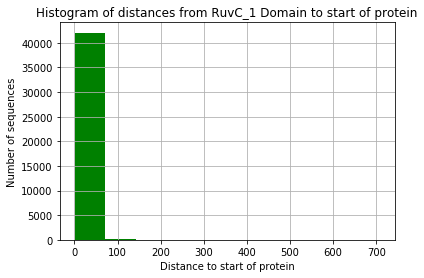

In [6]:
from pandas import Series
ruvC1Coords = []
ruvC3Coords = []
samples = []
difs = []
for sample in hasAllDomains:
    ruc1Start = hits.samples[sample]["RuvC_1_Cas9"].start
    ruc3End = hits.samples[sample]["RuvC_3_Cas9"].dend
    ruvC1Coords.append(ruc1Start)
    ruvC3Coords.append(ruc3End)
    difs.append(ruc3End-ruc1Start)
    samples.append(sample)
    
ruvC1Dists = Series(ruvC1Coords,index=samples)
ruvC3Dists = Series(ruvC3Coords,index=samples)

print ("\nMean distance from RuvC_1 to start of protein: %.0f std: %.0f" % (ruvC1Dists.mean(), ruvC1Dists.std()))

# the histogram of the data
n, bins, patches = plt.hist(ruvC1Dists,facecolor='green')
plt.xlabel('Distance to start of protein')
plt.ylabel('Number of sequences')
plt.title("Histogram of distances from RuvC_1 Domain to start of protein")
plt.grid(True)
plt.show()


Mean distance from RuvC_3 to end of protein: 278 std: 61


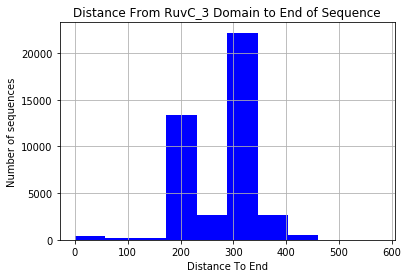

In [7]:
print ("\nMean distance from RuvC_3 to end of protein: %.0f std: %.0f" % (ruvC3Dists.mean(), ruvC3Dists.std()))

# the histogram of the data
n, bins, patches = plt.hist(ruvC3Dists,facecolor='blue')
plt.xlabel('Distance To End')
plt.ylabel('Number of sequences')
plt.title("Distance From RuvC_3 Domain to End of Sequence")
plt.grid(True)
plt.savefig("images/%s_RuvC3_DomainLengths.png" % gene)
plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4))
ax1.hist(ruvC1Coords,facecolor='green')
ax1.grid(True)
ax2.hist(ruvC3Coords,facecolor='blue') 
plt.grid(True)
plt.show();

In [8]:
import numpy as np
start_outliers = set(ruvC1Dists[ruvC1Dists > ruvC1Dists.mean()+2*ruvC1Dists.std()].index) #RuvC1 outlier
end_outliers = set(ruvC3Dists[ruvC3Dists > ruvC3Dists.mean()+2*ruvC3Dists.std()].index) #RuvC3 outlier
hasGoodDomains = hasAllDomains.difference(start_outliers.union(end_outliers))
htmlString ="""<table align='left'>
    """\
    "<tr style='background-color:#373D20;color:white'><td>No outlier domains</td><td>%i</td></tr>" % (len(hasGoodDomains)) +\
    "<tr style='background-color:#BCBD8B;color:white'><td>Number of RuvC1 outliers</td><td>%i</td></tr>" % (len(start_outliers)) +\
    "<tr style='background-color:#717744;color:white'><td>Number of RuvC3 outliers</td><td>%i</td></tr>" % (len(end_outliers)) +\
    "<tr style='background-color:#766153;color:white'><td>Outlier Intersection</td><td>%i</td></tr>" % (len(start_outliers.intersection(end_outliers))) +\
    """
    </table>
"""

#"<tr style='background-color:#766153;color:white'><td>Outlier Intersection</td><td>%i</td></tr>" % (len(start_outliers.intersection(end_outliers))) +\
# htmlString += "<br/><img src='nwks/%s.png' style='width:1000px;height:1000px;'>" % ("Cas9-Subtree1.V2")
display(HTML(htmlString))  
print(htmlString)
dump(hasGoodDomains,"pickles/%s_CorrectDomains.p" % gene)

No outlier domains,40706
Number of RuvC1 outliers,887
Number of RuvC3 outliers,632
Outlier Intersection,19


<table align='left'>
    <tr style='background-color:#373D20;color:white'><td>No outlier domains</td><td>40706</td></tr><tr style='background-color:#BCBD8B;color:white'><td>Number of RuvC1 outliers</td><td>887</td></tr><tr style='background-color:#717744;color:white'><td>Number of RuvC3 outliers</td><td>632</td></tr><tr style='background-color:#766153;color:white'><td>Outlier Intersection</td><td>19</td></tr>
    </table>


Dumping pickles/Cas9_CorrectDomains.p


In [9]:
goodDomIDS = set()
goodDomMap = {}
hasGoodDomains = load(open("pickles/%s_CorrectDomains.p" % gene, "rb"))
for prot in hasGoodDomains: 
    baseID = prot[:prot.rfind("_")] # remove the orf identifier
    goodDomIDS.add(baseID)
    try: goodDomMap[baseID].add(prot)
    except: goodDomMap[baseID] = set([prot])
print("Found %i Cas9-like proteins on the same sequence" % (len(hasGoodDomains) - len(goodDomIDS)))
print("Total proteins found %i in (%i == %i) sequences" % (len(hasGoodDomains),len(goodDomMap),len(goodDomIDS)))
dump(goodDomIDS,"pickles/%s_GoodDomainIDS.p" %(gene))
dump(goodDomMap,"pickles/%s_GoodDomMap.p" %(gene))

Found 159 Cas9-like proteins on the same sequence
Total proteins found 40706 in (40547 == 40547) sequences

Dumping pickles/Cas9_GoodDomainIDS.p

Dumping pickles/Cas9_GoodDomMap.p


# Now we have assemblies with a crispr and a Cas9. Next we will copy all of the unique seqeuences over to the same place. This will allow the systems with the same protein but different DNA sequences to exist.

In [4]:
assemblyDir = "assemblies/assemblies_W_%s/" % (gene)
cas9Assemblies = listdir(assemblyDir)
goodDomIDS = load(open("pickles/%s_GoodDomainIDS.p" % (gene), "rb"))
goodDomMap = load(open("pickles/%s_GoodDomMap.p"    % (gene), "rb"))
hmm_parser = load(open("pickles/%s_HMM_Parsing_Results.p" % (gene), "rb"))

In [13]:
assembliesWCrisprs = load(open("pickles/allAssemblyW_CRISPRs.p","rb"))

In [5]:
def getDB(aPath): 
    if "genbank" in aPath: return "genbank"
    if "refseq"  in aPath: return "refseq"
    return "pat2"
hmm_parser = load(open("pickles/%s_HMM_Parsing_Results.p" % (gene), "rb"))
len(hmm_parser)

48081

In [7]:
# Copy unique nucleotide sequence
from Bio.SeqIO import index, write
from os import system
# hmm_parser = load(open("pickles/%s_HMM_Parsing_Results.p" % (gene), "rb"))
hasGoodDomains = load(open("pickles/%s_CorrectDomains.p" % gene, "rb"))
# assembliesWCrisprs = load(open("pickles/allAssemblyW_CRISPRs.p","rb"))

nukSeqHash, protAssemblyMap, assemblyProtMap = {}, {}, {}
# BASEFILENAME eg GCF_0001232342.5.fasta = GCF_0001232342.5
# protAssemblyMap = {CHROM_ORF#:BASEFILENAME}

counter = 0
#casFiltered = open("proteins/All_%s-Like-filtered.faa" % gene, "w")
crPath = "/mnt/research/germs/shane/databases/crisprs/pilerCR"
for baseID, proteins in hmm_parser:
    assemblyProtMap[baseID] = {}
    protIDs = proteins.proteins.keys()
    keepers = hasGoodDomains.intersection(protIDs)
    if len(keepers) > 0:
#         seqs = index(assembliesWCrisprs[baseID], "fasta")
#         db = getDB(assembliesWCrisprs[baseID])
        for protID in keepers:
            counter += 1
            protAssemblyMap[protID] = baseID
            baseProtID = protID[:protID.rfind("_")]
            try: assemblyProtMap[baseID][baseProtID].add(protID)
            except: assemblyProtMap[baseID] = {baseProtID:set([protID])}
#             pchr = seqs[baseProtID]
#             nukeSeq = str(pchr.seq).upper()
#             if nukeSeq not in nukSeqHash:
#                 if not path.exists("crisprs/%s.pcrout" % (protID)):
#                     system("ln -s %s/%s/%s.pcrout crisprs/%s.pcrout" % (crPath,db,baseID,protID))
#                     with open("assemblies/pseudoChromos/%s.fasta" % protID, "w") as seqFH:
#                         pchr.id = protID
#                         write(pchr, seqFH, "fasta")
#                 write(proteins.proteins[protID],casFiltered,"fasta")
#                 nukSeqHash[nukeSeq] = set([protID])
#             else: nukSeqHash[nukeSeq].add(protID)
            if counter % 1000 == 0: print(counter/1000,end=' ')
# casFiltered.close()
# dump(nukSeqHash,"pickles/%s_nukSeqHash.p" % gene)
# dump(protAssemblyMap,"pickles/%s_protAssemblyMap.p" % gene)
dump(assemblyProtMap,"pickles/%s_assemblyProMap.p" % gene)

1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 
Dumping pickles/Cas9_assemblyProMap.p


#### Write all proteins to a file ->Cluster proteins -> Align the representatives

In [4]:
%%bash -s $gene
cd-hit -i proteins/All_$1-Like-filtered.faa -c .90 -d 0 -M 0 -T 0 -o proteins/$1-Like-clustered.faa >logs/$1_ClusterLog.log
tail -n 8 logs/$1_ClusterLog.log > logs/clusterInfo
head -n 1 logs/clusterInfo; rm logs/clusterInfo
mv proteins/$1-Like-clustered.faa.clstr clusters/

    23804  finished       2213  clusters


In [10]:
gene = "Cas9"
clusterID = ""
allClusters, allClusterSeqIDs = {},{}
clusterPercs = {}
for line in open("clusters/%s-Like-clustered.faa.clstr" % (gene)):
    line = line.strip()
    if ">Cluster" in line: clusterID = line.replace(">","")
    else:
        sequenceID = line[line.find(">")+1:line.find(".")] 
        seqID = line[line.find(">")+1:line.find("...")] 
        perc = line.split(" ")[-1]
        aa_s = line.split("\t")[1]
        aa_s = int(aa_s.split("aa,")[0])
        if "%" in perc: clusterPercs[seqID] = (aa_s,float(perc.replace("%","")))
        try:allClusters[clusterID].add(seqID)
        except:allClusters[clusterID]=set([seqID])
        try:allClusterSeqIDs[seqID].add(clusterID)
        except:allClusterSeqIDs[seqID]=set([clusterID])
allClusters, allClusterSeqIDs
dump(allClusters,"pickles/%s_ClusteringResults.p" % (gene))
dump(allClusterSeqIDs,"pickles/%s_RevClusteringResults.p" % (gene))
dump(clusterPercs,"pickles/%s_ClusterPercs.p" % (gene))


Dumping pickles/Cas9_ClusteringResults.p

Dumping pickles/Cas9_RevClusteringResults.p

Dumping pickles/Cas9_ClusterPercs.p


In [2]:
from Bio.SeqIO import index,write
from os import listdir
gene = "Cas9"
casAssemblies = index("data/proteins/%s-Like-clustered.faa" % (gene), "fasta")
casFH = open("data/assemblies/%s_Representative_Assemblies.fasta" % (gene), "w")
counter = 0
for fname in listdir("data/assemblies/pseudoChromos/"):
    seqID = fname[:fname.find(".fasta")]
    if seqID in casAssemblies: 
        asm = index("data/assemblies/pseudoChromos/"+fname, "fasta")
        write(asm[seqID],casFH,"fasta")
        if counter % 100 == 0 : print(counter/100,end=" ")
        counter +=1
casFH.close()
counter 

0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 

2213

In [20]:
dump(nukSeqHash,"pickles/%s_nukSeqHash.p" % gene)
dump(protAssemblyMap,"pickles/%s_protAssemblyMap.p" % gene)


Dumping pickles/Cas9_nukSeqHash.p

Dumping pickles/Cas9_protAssemblyMap.p


In [3]:
hmm_parser = HMM_Parser()
hmmFiles = os.listdir(hmmResultsDir)
counter, numWithCas9Like = 0, 0
print ("Working on the %s directory which contains %i files" % (hmmResultsDir,len(hmmFiles)))
for fileName in hmmFiles:
    if ".hmmout" not in fileName: continue
    fileStats = os.stat(os.path.join(hmmResultsDir,fileName)).st_size  
    counter+=1
    if counter % 100000 == 0: print(counter,numWithCas9Like)
    if fileStats < 1900: continue #Less than 1900 means no results were found
    hmm_parser.parse(os.path.join(hmmResultsDir,fileName))
    numWithCas9Like +=1
dump(hmm_parser,"pickles/%s_HMM_Parsing_Results.p" % (gene))

Working on the hmm/results directory which contains 401683 files
100000 13639
200000 27361
300000 40893

Dumping pickles/Cas9_HMM_Parsing_Results.p


In [10]:
protCounter, fileCounter = 0,1
protSeqs = set()
IDs, dupes = {},{}
casAll = open("proteins/All_%s-Like.faa" % gene,"w")
casUnique = open("proteins/Unique_%ss.faa" % gene,"w")
# fh = open("../scripts/hpc/hmmSearch/HMMSearch_0.sb","w")
# header = ""
# for line in open("../scripts/hpc/header.sb"): header+=line
# fh.write(header)

for baseID,proteins in hmm_parser:
    for protID, rec in proteins:
        if len(rec.seq) > 2100: continue
        if rec.id in IDs: 
            try: dupes[rec.id].add(baseID)
            except: 
                dupes[rec.id] = set([baseID])
                dupes[rec.id].add(IDs[rec.id])
            continue
        IDs[rec.id]=baseID
        seq = str(rec.seq).upper()
        protCounter +=1
        if seq not in protSeqs:
            
            protSeqs.add(seq)
            write(rec,casUnique,"fasta")
        write(rec,casAll,"fasta")
casUnique.close() 
casAll.close()
print("Number of dupes: ",len(dupes))
print ("Writing %i proteins from %i assemblies to file: proteins/All_%s-Like.faa" % (protCounter,numWithCas9Like,gene))
print("Of the %s proteins, there are %i unique proteins" % (protCounter,len(protSeqs)))

Number of dupes:  36
Writing 50353 proteins from 48081 assemblies to file: proteins/All_Cas9-Like.faa
Of the 50353 proteins, there are 8424 unique proteins


In [ ]:
from Bio.SeqIO import index,write
prots = index("proteins/All_%s-Like.faa" % (gene), "fasta")
fh = open("proteins/%s-Like.faa" % (gene),'w')
for fName in listdir("assemblies/pseudoChromos/"):
    orfID = fName.replace(".fasta","")
    prot = prots[orfID]
    write(prot,fh,"fasta")
fh.close()

In [ ]:
from Bio.SeqIO import index
fh = open("assemblies/%s_Representative_Assemblies.fasta" % (gene),"w")
prots = index("proteins/%s-Like-clustered.faa" % (gene), "fasta" )
for protName in prots.keys():
    protAsm = index("assemblies/pseudoChromos/%s.fasta" % (protName), "fasta")
#     seqID = protName[:protName.rfind("_")]
#     rec = protAsm[seqID]
#     rec.id = protName
    write(protAsm[protName],fh,"fasta")
fh.close()

In [ ]:
assembliesWCrisprs = load(open("pickles/allAssemblyCRISPRs.p","rb")) 

In [ ]:
from os import path, system
#fh = open("MissingCRISPS.txt","w")
#hmm_parser = load(open("pickles/%s_HMM_Parsing_Results.p"  % (gene), "rb"))
counter = 0    
crisprDir = "/mnt/research/germs/shane/databases/crisprs/pilerCR/"  
pcmd = "pilercr -minid 0.85 -mincons 0.8 -noinfo -in %s -out /mnt/research/germs/shane/databases/crisprs/pilerCR/%s/%s.pcrout 2>/dev/null" # % (assembly, outdir, assembly.replace(".fasta",""))
for fName, result in hmm_parser:
    keepers = prots.intersection(result.proteins.keys())
    for protID in keepers:
        db = "genbank"
        if "refseq" in assembliesWCrisprs[fName]: db = "refseq"
        if "PATRIC2" in assembliesWCrisprs[fName]: db = "pat2"
#         if not path.exists("crisprs/%s.pcrout" % protID):
#             system(pcmd % (assembliesWCrisprs[fName],db,fName))
#             fh.write(protID + "\t" + assembliesWCrisprs[fName] + "\n")
        system("unlink crisprs/%s.pcrout" % protID)
        system("ln -s /mnt/research/germs/shane/databases/crisprs/pilerCR/%s/%s.pcrout crisprs/%s.pcrout" % (db,fName,protID))
        counter +=1
counter
#fh.close()

In [ ]:
# hmm_parser = load(open("pickles/hmm_parsing_results.p","rb"))
# assembliesWCrisprs = load(open("pickles/allAssemblyCRISPRs.p","rb")) 
from os import system,path
counter = 0
protMapper = {}
for result in hmm_parser.results:
    fullHmmPath = result.filePath
    baseID = fullHmmPath.replace("hmm/results/","").replace(".hmmout","")
    if path.exists("assemblies/assemblies_W_Cas9s/%s.fasta" % (baseID)):
        counter+=1
        if counter % 1000 ==0: print(counter,end=" ")
        continue
    for rec in parse(assembliesWCrisprs[baseID],"fasta"):
        if rec.id in goodDomIDS:
            system("ln -s %s assemblies/assemblies_W_Cas9s/%s.fasta" % (assembliesWCrisprs[baseID],baseID))
            counter+=1
            if counter % 1000 ==0: print(counter,end=" ")
            break

#     for prot in result.proteins:
        

In [ ]:
from Bio.SeqIO import index as fasta_index
allCas9s = fasta_index("Cas9-Like-clustered.faa", "fasta")

### Alignment

In [ ]:
%%bash -s $gene
qsub alignment.sub
#mafft --maxiterate 1000 --globalpair --reorder --treeout $1-Like-clustered.faa > $1-Like-clustered.aln

In [ ]:
import glob, os
outliers = start_outlierIDs.union(end_outlierIDs)
files = glob.glob("assemblies/*.fasta")
for fileName in files:
    fileName2 = fileName.replace("assemblies/","").replace(".fasta","")
#     if fileName2 in outliers: 
#         os.system("mv %s* assemblies/NoDomains/" % (fileName.replace(".fasta","")))
        
removeSeqs = set(hits.samples).difference(hasDomains)

print len(hits.samples), len(removeSeqs), len(hits.samples) - len(removeSeqs)
files = glob.glob("assemblies/*.fasta")
for fileName in files:
    fileName2 = fileName.replace("assemblies/","").replace(".fasta","")
#     if fileName2 not in hits.samples: 
#         os.system("mv %s* assemblies/NoDomains/" % (fileName.replace(".fasta","")))
print "Total Samples:",len(hits.samples)
print "\tMissing Domain Samples:",len(removeSeqs)
print "\tDomain profile Samples:",len(outliers)
print "After filtering:", len(hits.samples) - (len(removeSeqs) + len(outliers))

counter=0
fh = open("Cas9-Like-clustered2.faa","w")
from Bio.SeqIO import parse
for rec in parse("Cas9-Like-clustered.faa","fasta"):
    if os.path.exists("assemblies/%s.fa" % (rec.id)):
        counter += 1
        fh.write(">%s\n%s\n" % (rec.id, str(rec.seq)))
fh.close()

### Cluster the results to remove duplicates

In [ ]:
%%bash -s $gene
cd-hit -i proteins/All_$1-Like.faa -c .9999999 -d 0 -M 0 -T 0 -o proteins/$1-Like-clustered.faa >logs/$1_ClusterLog.log
tail -n 8 logs/$1_ClusterLog.log

In [ ]:
from Bio.SeqIO import parse
fh = open("CasRelatedAssemblies2.fasta","w")
counter = 0
for rec in parse("CasRelatedAssemblies.fasta","fasta"):
    if os.path.exists("assemblies/%s.fa" % (rec.id)):
        counter += 1
        fh.write(">%s\n%s\n" % (rec.id, str(rec.seq)))
fh.close()
print counter

In [ ]:
%%bash
pwd

In [ ]:
files1 = set(glob.glob("assemblies/*.fasta"))
files2 = set(glob.glob("assemblies/*.fa"))
fastas,fas =set(),set()
for f in files2: fas.add(f.replace(".fa",""))
for f in files1: fastas.add(f.replace(".fasta",""))
for f in fas.difference(fastas):
    os.system("rm %s*" % (f))

In [ ]:
### Remove missing domains and length filtering
# Domain database pfam
# wget ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam31.0/Pfam-A.full.gz
dom_counter = {}
for line in open("/mnt/research/germs/shane/transActRNA/data/domains/Cas9-Like-clustered.faa.domtbl"):
    if "#" in line:continue
    rec = line.strip().split("    ")
#     print rec
#     break
    try:dom_counter[line.strip()]+=1
    except:dom_counter[line.strip()]=1
dom_counter = Counter(dom_counter)

In [ ]:
from Bio.SearchIO import HmmerIO
from Bio.SearchIO.HmmerIO import Hmmer3DomtabHmmhitParser as hmmParser

In [ ]:
hasHNH, hasRuvC= set(), set()
for x in hmmParser(open("/mnt/research/germs/shane/transActRNA/data/domains/DiverseCas9s1.domtbl")):
    if "HNH" == x.id:
        print x.id, len(x.hits)
        for hit in x.hits: hasHNH.add(hit.id)
    elif "RuvC" == x.id:
        print x.id, len(x.hits)
        for hit in x.hits: hasRuvC.add(hit.id)

In [ ]:
#Copy unique nucleotide sequence
from Bio.SeqIO import index
nukSeqHash,protSeqHash = set(), set()
alreadyGotIt,count = 0, 0
for assembly in cas9Assemblies:
    baseID = assembly[:-6]
    allAssemblySeqs = index(assemblyDir+assembly,"fasta")
    overlap = goodDomIDS.intersection(allAssemblySeqs.keys())
    for recID in overlap:
        seq = str(allAssemblySeqs[recID].seq).upper()
        if seq in nukSeqHash and len(goodDomMap[recID]) == 1:
            alreadyGotIt += 1
            continue
        nukSeqHash.add(seq)
        #There may be more than 1 protein on the pseudochromosome, save both as separate files  
        if len(goodDomMap[recID])>1: print("%i Cas9s on %s" %(len(goodDomMap[recID]),recID))
        for orfID in goodDomMap[recID]:
            with open("assemblies/pseudoChromos/%s.fasta" % (orfID),"w") as fh:
                write(rec,fh,"fasta")
                count +=1
        if count % 1000 == 0: print(count,end=" ")

In [ ]:
print "Number of proteins with both:", len(hasHNH.intersection(hasRuvC))


In [ ]:
for x in hmmParser(open("/mnt/research/germs/shane/CRISPR_Cas/data/domains/DiverseCas9s1.domtbl")):
    if "ruvc" in x.id.lower():
        print x.id, len(x.hits)
        for hit in x.hits:
            print "\t",hit.id

In [ ]:
definitions, descriptors, AC = {}, set(['AC','DE']), ""
important = set(["Cas9","nuclease","endonuclease", "HNH", "HnH", "RuvC", "ruvc", "RUVC", "HNH/ENDO", "CRISPR"])
for line in open("domains/Pfam-A.full"):
    rec = line.strip().split()
    if len(rec)<3 or rec[1] not in descriptors: continue
    if rec[1] == 'AC':AC = rec[2]
    else: definitions[AC] = " ".join(rec[2:])
print "Completed Loading %i definitions" % len(definitions)

In [ ]:
hnhDomainIDs = set()
for val in dom_counter.most_common(100):
    id,count = val[0], val[1]
    print "%s\t%i\t%s" % (id,count,definitions[id])
#     if "hnh" in definitions[id].lower():
#         hnhDomainIDs.add(id)
#         print "%s\t%i\t%s" % (id,count,definitions[id])
#     if "ruvc" in definitions[id].lower():
#         print "%s\t%i\t%s" % (id,count,definitions[id])

In [ ]:
def outliers(data,stdsAwayFromMean): return data[data > stdsAwayFromMean * data.std()]
start_outliers = outliers(ruvC1Dists,2) 
len(start_outliers)

from Bio.SeqIO import index

cas9Like = index("proteins/All_%s-Like.faa" % gene,"fasta")
allLengths = {}
for id,rec in cas9Like.items(): allLengths[id]=len(rec.seq)

In [ ]:
from Bio.SeqIO import parse
ids = set()
for rec in parse("%s-Like-clustered.faa" % gene,"fasta"): ids.add(rec.id[:-5])
db_path = "/mnt/research/germs/shane/databases/assemblies/NCBI/refseq"
for id in ids:
    os.system("cp %s/%s assemblies/" % (db_path,assembly_ids[id]))


In [ ]:
import pickle
from Bio.SeqIO import parse
db_path = "/mnt/research/germs/shane/databases/assemblies/NCBI/refseq"
files = os.listdir(db_path)
assembly_ids = {}
for fileName in files:
    for rec in parse(os.path.join(db_path,fileName),"fasta"): assembly_ids[rec.id]=fileName
print len(assembly_ids)
pickle.dump(assembly_ids,open("/mnt/research/germs/shane/databases/assemblies/NCBI/refseq_manifest.p","wb"))

#### Compare alignment methods

In [ ]:
from Bio.SeqIO import index
divCas9 = {} #index(geneProfile,"fasta")
gapCount, baseCount = 0,0
for rec in parse("alignments/Cas9.aln","fasta"): #default (more gaps less strict)
    for base in rec.seq:
        gapCount += int(base == "-")
        baseCount += int(base != "-")
    divCas9[rec.id]={'original':[gapCount,baseCount]}   
gapCount, baseCount = 0,0
for rec in parse("alignments/CCas9s.aln","fasta"): #local (Less gaps more strict)
    for base in rec.seq:
        gapCount += int(base == "-")
        baseCount += int(base != "-")
    divCas9[rec.id]["local"] = [gapCount,baseCount]
    
for id in divCas9:
    print("%i/%i\t%i/%i\t%s" % (divCas9[id]["local"][1],divCas9[id]["original"][1],divCas9[id]["local"][0],divCas9[id]["original"][0],id))
    

In [ ]:
from Bio.SeqIO import parse
import os
import pickle
print "Loading ncbi IDs"
assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/NCBI/refseq_manifest.p","rb"))
print "Loading patric2 IDs"
notInNCBI, ids,fullID = [], [], {}
for rec in parse("%s-Like-clustered.faa" % gene,"fasta"): 
    fullID[rec.id[:-5]] = rec.id
    ids.append(rec.id[:-5])
for id in ids:
    if id not in assembly_ids:
        notInNCBI.append(id)
        continue
    os.system("cp /mnt/research/germs/shane/databases/assemblies/NCBI/refseq/%s /mnt/research/germs/shane/CRISPR_Cas/data/assemblies/%s.fasta" % (assembly_ids[id],fullID[id]))
    print id,assembly_ids[id]


In [ ]:
print "Loading PATRIC IDs"
assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/PATRIC2/pat2_manifest.p","rb"))
print "Copying Files"
for id in notInNCBI:
    os.system("cp /mnt/research/germs/shane/databases/assemblies/PATRIC2/fastas/%s /mnt/research/germs/shane/CRISPR_Cas/data/assemblies/%s.fasta" % (assembly_ids[id],fullID[id]))
    print id,assembly_ids[id]

In [ ]:
#assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/NCBI/refseq_manifest.p","rb"))
#assembly_ids = pickle.load(open("/mnt/research/germs/shane/databases/assemblies/PATRIC2/pat2_manifest.p","rb"))
files = os.listdir("assemblies")
ids = set()
for fileName in files:ids.add(fileName.replace(".fasta",""))
for rec in parse("%s-Like-clustered.faa" % gene,"fasta"): 
    if rec.id not in ids:
        print rec.id,assembly_ids[rec.id[:-5]]

In [ ]:
%%bash
cd scripts
bash pilercrRun.sh &
bash pilercrRunFW.sh

In [ ]:
from ete3 import Tree, TreeStyle
# casTree=Tree("Cas9-Like-clustered.faa.tree")
# ts = TreeStyle()
# ts.mode = "c"
# ts.show_leaf_name = False
# casTree.render("Cas9.png",tree_style=ts)
#t.write(format=1, outfile="new_tree.nw")

In [ ]:
from ete3 import Tree, TreeStyle
rooted_tree = Tree( "((A,B),(C,D));" )
ts = TreeStyle()
ts.mode = "c"
rooted_tree.render("%%inline",tree_style=ts)

In [ ]:
from pandas import DataFrame, read_csv, Series
outfmt6_cols = ["qseqid","sseqid","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore"]
blastResults = read_csv("data/DiverseCompare.blastout",delimiter='\t', names=outfmt6_cols) 
len(blastResults)
blastResults
len(blastResults[blastResults.pident>90])

In [ ]:
len(blastResults[blastResults.pident>98])

#### Move large number of hmm files to an old run dir

In [ ]:
from os import system
files = os.listdir("hmm/results")
print(len(files))
for fname in files:
    mv_CMD = "mv hmm/results/%s hmm/results/oldRuns/"
    if fname[-4:] == "orfs": system("rm hmm/results/"+fname)
    elif (fname[-4:] == ".out"): system(mv_CMD % (fname))
    else:
        print(fname)

In [ ]:
%%bash
ls

In [ ]:
    if len(proteins.proteins) == 0:
        proteins.__get_proteins__(hmmResultsDir+baseID+".hmmout")
        nncount += 1
    if len(proteins.proteins) == 0:
        fh.write(getOrfsCMD % (assembliesWCrisprs[baseID],hmmResultsDir, baseID) + "\n")
        count+=1
        if count % 50 == 0:
            fh.close()
            fh = open("../scripts/hpc/hmmSearch/HMMSearch_%i.sb" % (fileCounter),"w")
            fileCounter += 1
            fh.write(header)
            
print(count,fileCounter,nncount)
fh.close()